In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score,accuracy_score

from category_encoders import TargetEncoder, BinaryEncoder, JamesSteinEncoder
from feature_engine.encoding import PRatioEncoder
from feature_engine.outliers import Winsorizer
from rfpimp import permutation_importances
from tqdm.notebook import tqdm
import optuna
from itertools import combinations
import imblearn

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('train_s3TEQDk.csv')
test = pd.read_csv('test_mSzZ8RL.csv')
sample = pd.read_csv('sample_submission_eyYijxG.csv')

In [3]:
train.shape, test.shape

((245725, 11), (105312, 10))

Variable
	

Definition

ID:Unique Identifier for a row

Gender:Gender of the Customer

Age:Age of the Customer (in Years)

Region_Code:Code of the Region for the customers

Occupation:Occupation Type for the customer

Channel_Code:Acquisition Channel Code for the Customer  (Encoded)

Vintage:Vintage for the Customer (In Months)

Credit_Product:If the Customer has any active credit product (Home loan,
Personal loan, Credit Card etc.)

Avg_Account_Balance:Average Account Balance for the Customer in last 12 Months

Is_Active:If the Customer is Active in last 3 Months

Is_Lead(Target):If the Customer is interested for the Credit Card
0 : Customer is not interested
1 : Customer is interested

In [ ]:
train.isnull().sum(axis=1).sample(15)

In [ ]:
train.isnull().sum(axis=0)

In [ ]:
test.head()

In [ ]:
train.Avg_Account_Balance = np.log1p(train.Avg_Account_Balance)

In [ ]:
train.shape

In [ ]:
asd = train.drop_duplicates()

In [ ]:
asd.shape

#### Feature Engg

In [ ]:
train.Region_Code.unique()

In [ ]:
train.Credit_Product.fillna(value='Missing', inplace=True, axis=0)
test.Credit_Product.fillna(value='Missing', inplace=True, axis=0)

In [ ]:
train['no'] = train.Region_Code.str.split('G', expand=True)[1]

In [ ]:
train['no_of_people_by_age'] = train.groupby(['Age'])['ID'].transform('count')
train['people_in_region'] = train.groupby('Region_Code')['ID'].transform('count')
train['vintage_by_id'] = train.groupby('Vintage')['ID'].transform('count')
train['prod_by_id'] = train.groupby('Credit_Product')['ID'].transform('count')
train['pred_by_age'] = train.groupby('Credit_Product')['ID'].transform('count')
train['prod_by_balance'] = train.groupby('Credit_Product')['Avg_Account_Balance'].transform('count')

In [ ]:
train['prod_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Credit_Product')['Avg_Account_Balance'].transform('count')
train['prod_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Credit_Product')['Avg_Account_Balance'].transform('mean')
train['age_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Age')['Avg_Account_Balance'].transform('count')
train['age_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Age')['Avg_Account_Balance'].transform('mean')
train['vintage_by_balance_count'] = train.Avg_Account_Balance - train.groupby('Vintage')['Avg_Account_Balance'].transform('count')
train['vintage_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Vintage')['Avg_Account_Balance'].transform('mean')
train['region_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Region_Code')['Avg_Account_Balance'].transform('count')
train['region_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Region_Code')['Avg_Account_Balance'].transform('mean')
train['occ_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Occupation')['Avg_Account_Balance'].transform('count')
train['occ_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Occupation')['Avg_Account_Balance'].transform('mean')
train['active_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Is_Active')['Avg_Account_Balance'].transform('count')
train['active_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Is_Active')['Avg_Account_Balance'].transform('mean')
train['gender_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Gender')['Avg_Account_Balance'].transform('count')
train['gender_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Gender')['Avg_Account_Balance'].transform('mean')
train['channel_by_balance_cnt'] = train.Avg_Account_Balance - train.groupby('Channel_Code')['Avg_Account_Balance'].transform('count')
train['channel_by_balance_mean'] = train.Avg_Account_Balance - train.groupby('Channel_Code')['Avg_Account_Balance'].transform('mean')


test['prod_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Credit_Product')['Avg_Account_Balance'].transform('count')
test['prod_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Credit_Product')['Avg_Account_Balance'].transform('mean')
test['age_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Age')['Avg_Account_Balance'].transform('count')
test['age_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Age')['Avg_Account_Balance'].transform('mean')
test['vintage_by_balance_count'] = test.Avg_Account_Balance - test.groupby('Vintage')['Avg_Account_Balance'].transform('count')
test['vintage_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Vintage')['Avg_Account_Balance'].transform('mean')
test['region_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Region_Code')['Avg_Account_Balance'].transform('count')
test['region_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Region_Code')['Avg_Account_Balance'].transform('mean')
test['occ_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Occupation')['Avg_Account_Balance'].transform('count')
test['occ_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Occupation')['Avg_Account_Balance'].transform('mean')
test['active_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Is_Active')['Avg_Account_Balance'].transform('count')
test['active_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Is_Active')['Avg_Account_Balance'].transform('mean')
test['gender_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Gender')['Avg_Account_Balance'].transform('count')
test['gender_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Gender')['Avg_Account_Balance'].transform('mean')
test['channel_by_balance_cnt'] = test.Avg_Account_Balance - test.groupby('Channel_Code')['Avg_Account_Balance'].transform('count')
test['channel_by_balance_mean'] = test.Avg_Account_Balance - test.groupby('Channel_Code')['Avg_Account_Balance'].transform('mean')

In [ ]:
train.Avg_Account_Balance - train.groupby('Is_Active')['Avg_Account_Balance'].transform('mean')

In [ ]:
train.head()

In [ ]:
train['age_by_id_max']= train.groupby(['Age'])['ID'].transform('max')
train['age_by_id_min']= train.groupby(['Age'])['ID'].transform('min')
train['age_by_id_cnt']= train.groupby(['Age'])['ID'].transform('count')

In [ ]:
train['age_occ_by_id_max']= train.groupby(['Age','Occupation'])['ID'].transform('max')
train['age_occ_by_id_min']= train.groupby(['Age','Occupation'])['ID'].transform('min')
train['age_occ_by_id_cnt']= train.groupby(['Age','Occupation'])['ID'].transform('count')

In [ ]:
train.groupby(['Age'])['ID'].count()

In [ ]:
cat_cols = [var for var in train.columns if train[var].dtypes == 'O']

In [ ]:
cat_cols

In [ ]:
for col in (train.columns):
    train[col] = train[col].factorize()[0]

In [ ]:
def gender_empty1(df):
    if df['Credit_Product'] == np.nan:
        return 1
    else:
        return 0

In [ ]:
train['cred_prod_empty'] = train.apply(lambda train: gender_empty1(train), axis = 1)
test['cred_prod_empty'] = test.apply(lambda train: gender_empty1(train), axis = 1)

In [ ]:
training.isnull().sum()

In [ ]:
cat_features=[]
    
#Interaction Feature (Combining 2 categorical features and performing frequency encoding)
    
columns=[
 'Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Is_Active']
comb = combinations(columns, 2) 

for i in list(comb):
    train[f'{i[0]}_{i[1]}']=train[i[0]].astype(str)+'_'+train[i[1]].astype(str)
    test[f'{i[0]}_{i[1]}']=test[i[0]].astype(str)+'_'+test[i[1]].astype(str)

In [ ]:
train['region_cred'] = train.Region_Code.astype(str) + '_' + train.Credit_Product.astype(str)
train['cred_active'] = train.Credit_Product.astype(str) + '_' + train.Is_Active.astype(str)

In [ ]:
train['age - vintage'] = train.Age - train.Vintage

In [ ]:
train['Balance_by_vintage'] = train.Avg_Account_Balance/train.Vintage
test['Balance_by_vintage'] = test.Avg_Account_Balance/test.Vintage

In [ ]:
train.groupby(['Credit_Product'])['Age'].count()

In [ ]:
train['Monthly'] = (train.Avg_Account_Balance/12)
test['Monthly'] = (test.Avg_Account_Balance/12)

In [ ]:
#train['Vintage_yearly'] = pd.cut(train.Vintage, bins=[0,12,24,36,48,60,72,84,96,108,120,132,135], labels=False)

In [ ]:
train['Monthly*Vintage'] = train.Monthly * train.Vintage
test['Monthly*Vintage'] = test.Monthly * test.Vintage

In [ ]:
train['occ_region_by_credit'] = train.groupby(['Occupation', 'Region_Code'])['Credit_Product'].transform('count')

In [ ]:
train.isnull().sum()

In [ ]:
train['age_by_balance'] = train['Avg_Account_Balance'] - train.groupby(['Credit_Product'])['Avg_Account_Balance'].transform('mean')

In [ ]:
train.groupby(['Age'])['Avg_Account_Balance'].transform('mean')

In [ ]:
train['active_users_by_region'] = train.groupby(['Region_Code'])['Is_Active'].transform('count')
train['active_users_by_occupation'] = train.groupby(['Occupation'])['Is_Active'].transform('count')


test['active_users_by_region'] = test.groupby(['Region_Code'])['Is_Active'].transform('count')
test['active_users_by_occupation'] = test.groupby(['Occupation'])['Is_Active'].transform('count')

In [ ]:
train['Credit_Product_by_vintage'] = train.groupby(['Vintage'])['Credit_Product'].transform('count')
train['Credit_Product_by_region'] = train.groupby(['Region_Code'])['Credit_Product'].transform('count')
train['Credit_Product_by_Age'] = train.groupby(['Age'])['Credit_Product'].transform('count')


test['Credit_Product_by_vintage'] = test.groupby(['Vintage'])['Credit_Product'].transform('count')
test['Credit_Product_by_region'] = test.groupby(['Region_Code'])['Credit_Product'].transform('count')
test['Credit_Product_by_Age'] = test.groupby(['Age'])['Credit_Product'].transform('count')

In [ ]:
#train['Occ_by_channel'] = train.groupby(['Occupation'])['Channel_Code'].transform('count')

In [ ]:
train.groupby(['Channel_Code'])['Occupation'].count()

In [ ]:
train.groupby(['Occupation'])['Channel_Code'].nunique()

In [ ]:
train = train.merge(df, on=['Region_Code'], how= 'left')

In [ ]:
train.query("Credit_Product == 'No'")

In [ ]:
train['Actual_balance'] = train.Avg_Account_Balance * 12

In [ ]:
train['6_monthly'] = (train.Monthly * 6)
train['3_monthly'] = (train.Monthly * 3)

In [ ]:
train.nunique()

In [ ]:
sns.countplot(train.Gender)

In [ ]:
sns.boxplot(train.Age)

In [ ]:
sns.distplot(train.Age)

In [ ]:
plt.figure(figsize=(25,6))
sns.countplot(train.Region_Code)

In [ ]:
sns.countplot(train.Occupation)

In [ ]:
sns.countplot(train.Channel_Code)

In [ ]:
sns.distplot(train.Vintage)

In [ ]:
sns.boxplot(train.Vintage)

In [ ]:
sns.countplot(train.Credit_Product)

In [ ]:
sns.distplot(X_train.Avg_Account_Balance)
print(train.Avg_Account_Balance.skew())

In [ ]:
sns.distplot(np.log1p(train.Avg_Account_Balance))
print(np.log1p(train.Avg_Account_Balance).skew())

In [ ]:
sns.boxplot(X_train.Avg_Account_Balance)

In [ ]:
sns.boxplot(np.sqrt(train.Avg_Account_Balance))

In [ ]:
win = Winsorizer(capping_method='gaussian', tail='right', fold=1.5, variables=['Avg_Account_Balance'])

In [ ]:
X_train = win.fit_transform(X_train)
#X_test = win.transform(X_test)

In [ ]:
sns.distplot(X_train.Avg_Account_Balance)

In [ ]:
sns.countplot(train.Is_Active)

In [ ]:
sns.heatmap(train.corr(), annot=True)

In [ ]:
training.isnull().sum()

In [4]:
training, testing = train_test_split(train, test_size = 0.3, random_state= 2021, stratify = train.Is_Lead)

In [ ]:
[var for var in training.columns if training[var].dtypes != 'O']

In [7]:
cont_cols = ['Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active']

In [8]:
X_train = training[cont_cols]
y_train = training.Is_Lead
X_test = testing[cont_cols]
y_test = testing.Is_Lead

In [ ]:
training.head()

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(training.corr(), annot=True)

In [ ]:
sc = RobustScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Basically without any modification to data.....we can get score upto 87.23%

In [ ]:
models = [GradientBoostingClassifier(),AdaBoostClassifier(), XGBClassifier(), 
          LGBMClassifier(), LogisticRegression(max_iter=1000)]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)
    print('For the model: ', model, 'we get the score of: ', roc_auc_score(y_test, pred[:,1]))

In [ ]:
train.query("Occupation == 'Other' and Channel_Code == 'X3'").isnull().sum()

In [ ]:
train.isnull().sum()

In [ ]:
params_lgbm

In [ ]:
params_lgbm1 = {
 'metric': 'auc',
 'reg_lambda': 0.20223035780776089,
 'reg_alpha': 0.011492160234855359,
 'colsample_bytree': 0.8,
 'subsample': 0.6,
 'learning_rate': 0.09043670684119678,
 'max_depth': 7,
 'min_child_samples': 268,
 'num_leaves': 56}

In [ ]:
params_lgbm2 = {
 'metric': 'auc',
 'reg_lambda': 0.5042783261960986,
 'reg_alpha': 0.3241067100673235,
 'colsample_bytree': 0.7,
 'subsample': 0.6,
 'learning_rate': 0.09837153547687248,
 'max_depth': 7,
 'min_child_samples': 171,
 'num_leaves': 89}

In [ ]:
params_lgbm3 = {
 'reg_lambda': 0.24916738577377065,
 'reg_alpha': 0.9514865057617112,
 'colsample_bytree': 0.7,
 'subsample': 0.7,
 'learning_rate': 0.06269102035495595,
 'max_depth': 7,
 'min_child_samples': 137,
 'num_leaves': 116}

In [ ]:
params_lgbm = {
 'n_estimators': 50,
 'n_estimators': 60,
 'reg_lambda': 1.162598140540772,
 'reg_alpha': 0.016423687168913046,
 'colsample_bytree': 0.6,
 'subsample': 0.6,
 'learning_rate': 0.08913914708906513,
 'max_depth': 15,
 'min_child_samples': 56,
 'num_leaves': 44}

In [ ]:
import lightgbm as lgbm

In [ ]:
dtrain = lgbm.Dataset(X_train, y_train)
dvalid = lgbm.Dataset(X_test, y_test)

In [ ]:
modeling = lgbm.train(params_lgbm1, dtrain, valid_sets=[dtrain, dvalid], verbose_eval=200, num_boost_round= 100000)
y_pred= modeling.predict(X_test)
print(roc_auc_score(y_test, y_pred))

In [ ]:
model1 = LGBMClassifier(**params_lgbm)
model1.fit(X_train, y_train)
pred = model1.predict_proba(X_test)
#print(roc_auc_score(y_test, pred[:,1]))

In [ ]:
model2 = LGBMClassifier(**params_lgbm2)
model2.fit(X_train, y_train)
pred = model2.predict_proba(X_test)
print(roc_auc_score(y_test, pred[:,1]))

In [ ]:
model3 = LGBMClassifier(**params_lgbm3)
model3.fit(X_train, y_train)
pred = model3.predict_proba(X_test)
#print(roc_auc_score(y_test, pred[:,1]))

In [ ]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
bag1 = BaggingClassifier(base_estimator=LGBMClassifier(**params_lgbm1), max_features=X_train.shape[1], bootstrap=True)
bag1.fit(X_train, y_train)
predict = bag1.predict_proba(X_test)
#print(roc_auc_score(y_test, predict[:,1]))

In [ ]:
bag3 = BaggingClassifier(base_estimator=LGBMClassifier(**params_lgbm3), max_features=X_train.shape[1], bootstrap=True)
bag3.fit(X_train, y_train)
predict = bag3.predict_proba(X_test)
#print(roc_auc_score(y_test, predict[:,1]))

In [12]:
model = LGBMClassifier(boosting_type='gbdt',
    num_leaves=30,
    max_depth=7,
    learning_rate=0.1,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    silent=True,
    importance_type='split')
model.fit(X_train, y_train)
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.8768892732675941


In [30]:
pd.crosstab(train.Gender, train.Credit_Product, normalize='index').sort_values(ascending=False)

TypeError: sort_values() missing 1 required positional argument: 'by'

In [24]:
pd.crosstab(train.Gender, train.Channel_Code, normalize='index')

Channel_Code,X1,X2,X3,X4
Gender,,,,
Female,0.521977,0.218752,0.239859,0.019412
Male,0.339076,0.322876,0.312682,0.025366


In [ ]:
predict = model.predict(X_test)

In [ ]:
testing['target'] = pd.DataFrame(predict)

In [ ]:
pred

In [ ]:
pred = pd.DataFrame()
pred['target'] = predict

In [13]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(20,18))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [14]:
def r2(rf, X_train, y_train):
    pred = model.predict_proba(X_train)
    return roc_auc_score(y_train, pred[:, 1])

In [15]:
perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

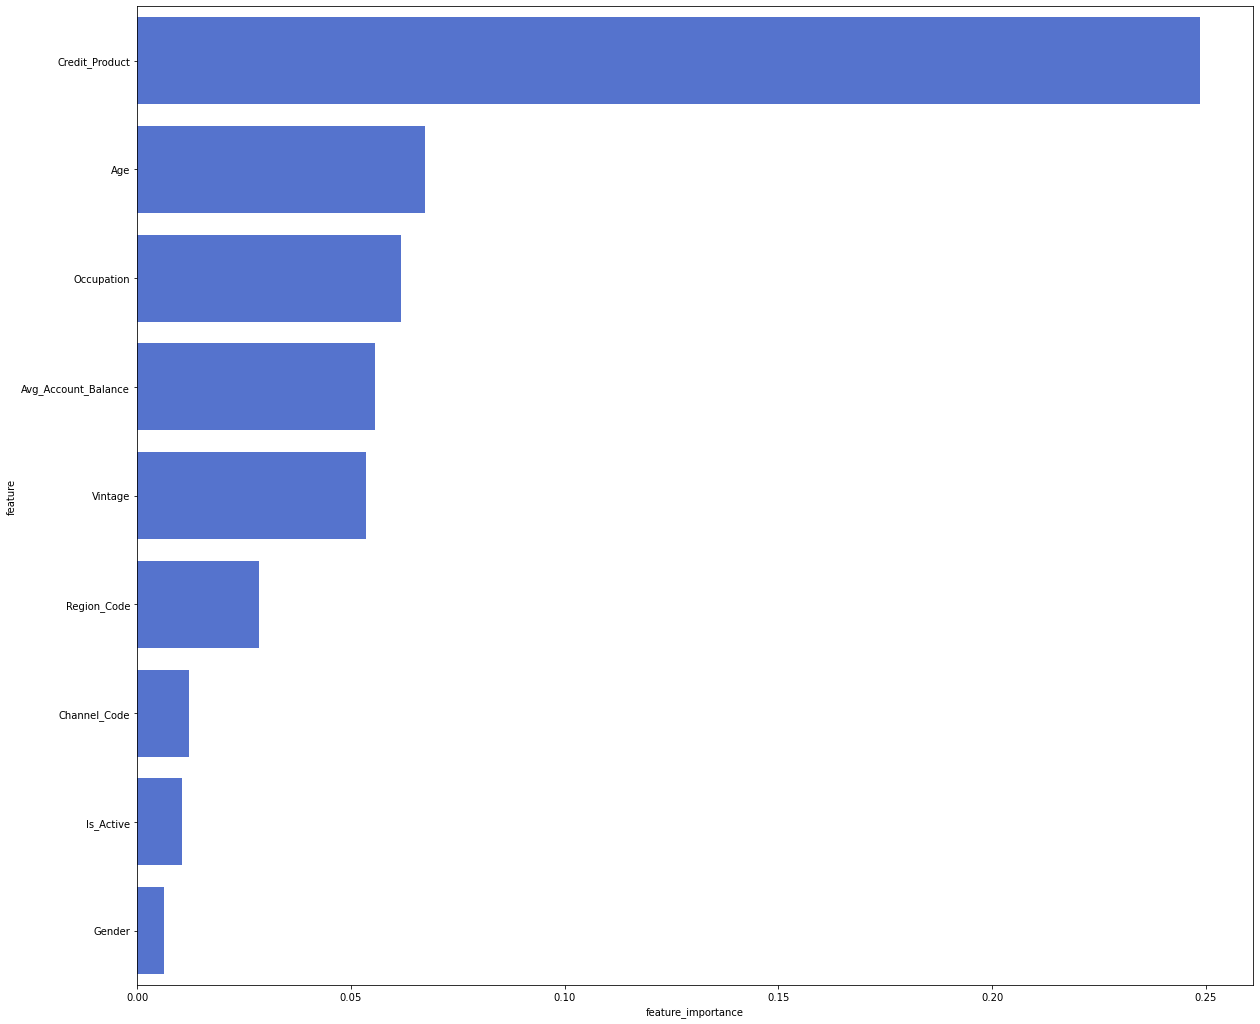

In [16]:
var_imp_plot(perm_imp_rfpimp)

<AxesSubplot:>

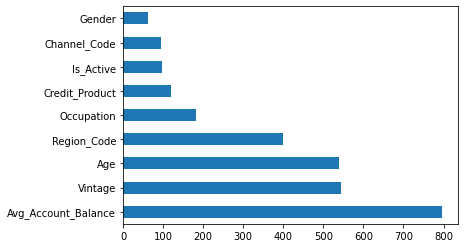

In [17]:
(pd.Series(model.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh'))  

In [ ]:
train.Region_Code.nunique()

In [ ]:
[var for var in training.columns if training[var].dtypes == 'O']

In [5]:
cat_cols = [
 'Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [6]:
be = TargetEncoder(smoothing=0.1)
be.fit(training[cat_cols], training.Is_Lead)
training[cat_cols] = be.transform(training[cat_cols], training.Is_Lead)
testing[cat_cols] = be.transform(testing[cat_cols])

C:\Anaconda\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Anaconda\lib\site-packages\pandas\core\frame.py:3188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
NUM_FOLDS = 10
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)
roc_auc = []

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X_train, y_train))):
    print('==================', f+1, '====================')
    train_df, val_df = X_train.iloc[train_ind], X_train.iloc[val_ind]
    train_target, val_target = y_train.iloc[train_ind], y_train.iloc[val_ind]
        
    model = XGBClassifier()
    model.fit(train_df, train_target)
    print('Train set')
    pred = model.predict_proba(train_df)
    print('Cat roc-auc on Train data: {}'.format(roc_auc_score(train_target, pred[:, 1])))

    print('Val set')
    pred_val = model.predict_proba(val_df)
    print(roc_auc_score(val_target, pred_val[:, 1]))
    pred_test = model.predict_proba(X_test)
    print(roc_auc_score(y_test, pred_test[:,1])) 
    roc_auc.append(roc_auc_score(val_target, pred_val[:, 1]))
print('Final prediction:====',np.mean(roc_auc))
print('LETS SEE:',roc_auc_score(y_test, pred_test[:,1]))
#Final prediction:==== 0.8701031427790922
#LETS SEE: 0.8740714708637237
#Final prediction:==== 0.8725134527817534
#LETS SEE: 0.876757292201171


In [ ]:
NUM_FOLDS = 10
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)
roc_auc = []

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X_train, y_train))):
    print('==================', f+1, '====================')
    train_df, val_df = X_train.iloc[train_ind], X_train.iloc[val_ind]
    train_target, val_target = y_train.iloc[train_ind], y_train.iloc[val_ind]
        
    model = LGBMClassifier(**params_lgbm3)
    model.fit(train_df, train_target)
    print('Train set')
    pred = model.predict_proba(train_df)
    print('Cat roc-auc on Train data: {}'.format(roc_auc_score(train_target, pred[:, 1])))

    print('Val set')
    pred_val = model.predict_proba(val_df)
    print(roc_auc_score(val_target, pred_val[:, 1]))
    pred_test = model.predict_proba(X_test)
    #print(roc_auc_score(y_test, pred_test[:,1])) 
    roc_auc.append(roc_auc_score(val_target, pred_val[:, 1]))
print('Final prediction:====',np.mean(roc_auc))
#print('LETS SEE:',roc_auc_score(y_test, pred_test[:,1]))
#Final prediction:==== 0.8724141869363187
#LETS SEE: 0.8766329068966433
#Final prediction:==== 0.8726935283769887
#LETS SEE: 0.8770423259883842
#Final prediction:==== 0.8725778285338446
#LETS SEE: 0.8770148682600016
#Final prediction:==== 0.8725477077538478
#LETS SEE: 0.8766009958490295


In [ ]:
NUM_FOLDS = 10
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)
roc_auc = []

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X_train, y_train))):
    print('==================', f+1, '====================')
    train_df, val_df = X_train.iloc[train_ind], X_train.iloc[val_ind]
    train_target, val_target = y_train.iloc[train_ind], y_train.iloc[val_ind]
        
    model = CatBoostClassifier(verbose=0)
    model.fit(train_df, train_target)
    print('Train set')
    pred = model.predict_proba(train_df)
    print('Cat roc-auc on Train data: {}'.format(roc_auc_score(train_target, pred[:, 1])))

    print('Val set')
    pred_val = model.predict_proba(val_df)
    print(roc_auc_score(val_target, pred_val[:, 1]))
    pred_test = model.predict_proba(X_test)
    print(roc_auc_score(y_test, pred_test[:,1])) 
    roc_auc.append(roc_auc_score(val_target, pred_val[:, 1]))
print('Final prediction:====',np.mean(roc_auc))
print('LETS SEE:',roc_auc_score(y_test, pred_test[:,1]))
#Final prediction:==== 0.87100714956351
#LETS SEE: 0.8751802807406818

In [ ]:
submission = pd.DataFrame()
submission['ID'] = sample.ID
submission['Is_Lead'] = predict[:,1]
submission.to_csv('sub15.csv',index=False)
submission.head()

In [ ]:
sample.head()

In [ ]:
def objective(trial):    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        'random_state': 10,
        #'random_state': trial.suggest_int('random_state', 0,2021),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001,0.1),
        #'n_estimators': trial.suggest_int("n_estimators", 50, 5000),
        'max_depth': trial.suggest_categorical('max_depth', [4,5,7,9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'num_leaves': trial.suggest_int('num_leaves', 15, 120),
    }
    model = LGBMClassifier(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict_proba(X_test)
    
    roc = roc_auc_score(y_test, preds[:,1])
    
    return roc

In [ ]:
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective, n_trials=150)
print("Number of finished trials: {}".format(len(study_lgbm.trials)))
print("Best trial:", study_lgbm.best_trial.params)

In [ ]:
params_lgbm = study_lgbm.best_params

In [ ]:
study_lgbm.best_params

In [ ]:
def get_models():
    model1 = LGBMClassifier(**params_lgbm)

    model2 = LGBMClassifier(**params_lgbm3)

    model3 = LGBMClassifier(**params_lgbm3)
    
    models = {'XGB':model1, 'CAT':model2, 'LGBM':model3}

    return models

In [ ]:
base_learners = get_models()
meta_learner = LGBMClassifier(**params_lgbm3)

In [ ]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=10,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_test)


In [ ]:
roc_auc_score(y_test, p_sl[:,1])

In [ ]:
import xgboost as xgb
def objective_xgb(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        'eval_metric':'auc',
        'max_depth':trial.suggest_int('max_depth', 2, 25),
        'reg_alpha':trial.suggest_int('reg_alpha', 0, 5),
        'reg_lambda':trial.suggest_int('reg_lambda', 0, 5),
        'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
        'gamma':trial.suggest_int('gamma', 0, 5),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
        'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.001),
        'nthread' : -1}
        
    
    gbm = XGBClassifier(**param, verbose=0)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose = 0)

    preds = gbm.predict_proba(X_test)

    roc = roc_auc_score(y_test, preds[:,1])
    return roc


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgb, n_trials=50)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:", study.best_trial.params)

In [ ]:
param_xgb = study.best_params

In [ ]:
param_xgb

In [ ]:
param_xgb= {'max_depth': 7,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'min_child_weight': 4,
 'gamma': 2,
 'learning_rate': 0.1009794032340597,
 'colsample_bytree': 0.689}

In [ ]:
def objective_cat(trial):
    param = {
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 15),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'learning_rate':trial.suggest_loguniform('learning_rate',0.005,0.5),
        "used_ram_limit": "3gb",
    }
    gbm = CatBoostClassifier(**param, verbose = 0)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose = 0)

    preds = gbm.predict_proba(X_test)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(y_test, preds[:,1])
    return accuracy


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_cat, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:", study.best_trial.params)

In [ ]:
def get_models():
    model1 = XGBClassifier(n_estimators= 20)

    model2 = XGBClassifier(n_estimators = 30)

    model3 = LGBMClassifier(n_estimators=120)
    
    model4 = LGBMClassifier(n_estimators=130)
    
    models = {'XGB':model1, 'CAT':model2, 'LGBM':model3, 'LGBM2':model4}

    return models

In [ ]:
base_learners = get_models()
meta_learner = LGBMClassifier()

In [ ]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=10,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test, p_sl[:,1])

In [ ]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
models = [XGBClassifier(), LGBMClassifier(), LogisticRegression(max_iter=1000)]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)
    print('For the model: ', model, 'we get the score of: ', roc_auc_score(y_test, pred[:,1]))

In [ ]:
n = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,250,300, 500,1000,2000,5000]
results = []
for i in n:
    model = LGBMClassifier(n_estimators=i, **params_lgbm)
    model.fit(X_train, y_train)
    predict = model.predict_proba(X_test)
    results.append(roc_auc_score(y_test, predict[:,1]))
    print('For n_estimator: ', i, 'we get score: ', roc_auc_score(y_test, predict[:,1]))
    print('***************************************')
plt.figure(figsize=(10,8))
pd.Series(results, n).plot();
print(np.max(results))

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
estimator = [('lgbm1', LGBMClassifier(**params_lgbm1),
             'lgbm2', LGBMClassifier(**params_lgbm2),
             'lgbm3', LGBMClassifier(**params_lgbm3))]

In [ ]:
from mlxtend.classifier import StackingClassifier

In [ ]:
lgbm1 = LGBMClassifier(**params_lgbm)
lgbm2 = LGBMClassifier(**params_lgbm2)
lgbm3 = LGBMClassifier(**params_lgbm3)

In [ ]:
stack = StackingClassifier(classifiers=(lgbm1, lgbm2, lgbm3),meta_classifier=lgbm3, average_probas=True,
                           use_features_in_secondary=True)

In [ ]:
stack.fit(X_train, y_train)

In [ ]:
roc_auc_score(y_test, stack.predict_proba(X_test)[:,1])

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dropout, LeakyReLU, Activation, Dense, Flatten
import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
ann = Sequential()
ann.add(Dense(512, activation='relu'))
ann.add(Dense(128, activation='relu'))
ann.add(Dropout(0.4))
ann.add(Dense(64, activation='relu'))
ann.add(Dense(32, activation='relu'))
ann.add(Dropout(0.3))
ann.add(Dense(16, activation='relu'))
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='sigmoid'))

In [ ]:
ann.compile(optimizer=keras.optimizers.Adam(), loss= keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
ann.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), shuffle=True)

In [ ]:
predict = ann.predict(X_test)

In [ ]:
roc_auc_score(y_test, predict)

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
estimators = [('LGBM1', bag1), ('LGBM2', bag3), ('LGBM3', model3)]

In [ ]:
kfold = StratifiedKFold(n_splits=10,shuffle=True, random_state=10)
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,1,1])
results = cross_val_score(ensemble, X_train, y_train, cv=kfold, scoring='roc_auc')
print('ROC_AUC on train: ',results.mean())
ensemble_model = ensemble.fit(X_train,y_train)
pred = ensemble_model.predict_proba(X_test)
#print('ROC_AUC on test:' , roc_auc_score(y_test, pred[:,1]))